In [1]:
import pandas as pd

In [2]:
import torch

In [3]:
# !watch -n 0.5 nvidia-smi

In [4]:
print(torch.__version__)  # 1.9.1+cu111
print(torch.version.cuda)  # 11.1
print(torch.backends.cudnn.version())  # 8005
print(torch.cuda.current_device())  # 0
print(torch.cuda.is_available())  # TRUE

2.0.1
11.8
8700
0
True


In [5]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "False"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [6]:
!nvidia-smi

Fri Sep 22 11:42:04 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti      On | 00000000:18:00.0 Off |                  N/A |
| 28%   28C    P8                3W / 250W|      1MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()   

Initial GPU Usage
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 72% |
|  1 |  99% | 72% |
|  2 | 100% | 72% |
|  3 | 100% | 72% |
GPU Usage after emptying the cache
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 72% |
|  1 |  99% | 72% |
|  2 | 100% | 73% |
|  3 | 100% | 72% |


In [8]:
data = pd.read_csv("TD_dataset_clean.csv" , index_col = 0)

In [9]:
data

,text_clean,label
0,look for min file instead,1
1,as an extension of 78,1
2,bountysourceplugin want to back this issue pla...,1
3,our grunt script is out of control its current...,1
4,jshint is dropping stylerelated support it see...,1
...,...,...
127686,ci is no more ok all i could see right now is ...,0
127687,agentwebfragment 打开其他网址没问题，打开httpsopenapialipa...,0
127688,this wouldnt quite be the same as an installpa...,0
127689,oh no a bug it happens thanks for reporting an...,0


In [10]:
import datasets
import transformers

print(transformers.__version__)
print(datasets.__version__)

/itf-fi-ml/home/nehad/.conda/envs/dl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4.33.2
2.14.5


In [11]:
import datasets
from datasets import load_dataset, Dataset, DatasetDict

In [12]:
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
)

In [13]:
base_model_id = "distilbert-base-uncased"

epochs = 5
num_labels = 2 
learning_rate = 5e-5
train_batch_size = 16
eval_batch_size = 32
save_strategy = "no"
save_steps = 500
logging_steps = 100
model_dir = "./model"

In [14]:
import numpy as np

def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

## Load Datasets

In [15]:
data.dropna(inplace=True)

In [16]:
data.reset_index(inplace=True)

In [17]:
data.drop(columns= ["index"], inplace = True)

In [18]:
data

,text_clean,label
0,look for min file instead,1
1,as an extension of 78,1
2,bountysourceplugin want to back this issue pla...,1
3,our grunt script is out of control its current...,1
4,jshint is dropping stylerelated support it see...,1
...,...,...
127671,ci is no more ok all i could see right now is ...,0
127672,agentwebfragment 打开其他网址没问题，打开httpsopenapialipa...,0
127673,this wouldnt quite be the same as an installpa...,0
127674,oh no a bug it happens thanks for reporting an...,0


In [19]:
train , validate , test = train_validate_test_split(data)

In [20]:

train.set_index("label" , inplace = True)
validate.set_index("label" , inplace = True)
test.set_index("label" , inplace = True)

In [21]:
test

,text_clean
label,
0,following of httpsgithubcomepinioepinioissues1...
0,1 la opción del menú despegable no es seleccio...
1,should not send connection ids connected boole...
1,a lot of the redux logic in vaos especially in...
0,when creating a simple table graph the button ...
...,...
0,randomize the fight order at the beginning of ...
1,part of the skip test audithttpsgithubcomflutt...
1,it might be a good idea to introduce jqwik pro...


In [22]:
tds = Dataset.from_pandas(train)
vds = Dataset.from_pandas(validate)
testds = Dataset.from_pandas(test)

ds = DatasetDict()

ds["test"] = testds
ds["train"] = tds
ds["validate"] = vds

ds

DatasetDict({
    test: Dataset({
        features: ['text_clean', 'label'],
        num_rows: 25536
    })
    train: Dataset({
        features: ['text_clean', 'label'],
        num_rows: 76605
    })
    validate: Dataset({
        features: ['text_clean', 'label'],
        num_rows: 25535
    })
})

In [23]:
train_dataset = ds["train"]
valid_dataset = ds["validate"]

In [24]:
ds["train"][0]


{'text_clean': 'description often one needs to reference previous answers or data as part of the questions in the current conversation these answersdata may come from 3 sources 1 registration data 2 attributes derived from previous answers in same conversation 3 attributes from other conversations why use case 1 variables from user registration data eg name email hi name use case 2 attributes from previous answers in same conversation in the last question you said attributeaesthetics in conversation use case 3 attributes from previous conversations you would like to become attributedesiredoccupation implementation wise 2 and 3 may be the same alternatives we will need to skip any references to previous answers in the conversation that will make the conversations less personable and natural',
 'label': 0}

In [25]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(base_model_id, num_labels=num_labels)
tokenizer = AutoTokenizer.from_pretrained(base_model_id)
# optim = torch.optim.Adam(model.parameters(), lr=5e-5)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Tokenization

    Character tokenization

In [27]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)


['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [28]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)


{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [29]:

input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)


[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [30]:

import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape


torch.Size([38, 20])

In [31]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")


Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


    Word Tokenization

In [32]:

tokenized_text = text.split()
print(tokenized_text)


['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


Some word tokenizers have extra rules for punctuation. One can also apply stemming or lemmatization, which normalizes words to their stem (e.g., "great", "greater", and "greatest" all become "great"), at the expense of losing some information in the text.

Having a large vocabulary is a problem because it requires neural networks to have an enormous number of parameters. To illustrate this, suppose we have 1 million unique words and want to compress the 1-million-dimensional input vectors to 1-thousand-dimensional vectors in the first layer of our neural network. This is a standard step in most NLP architectures, and the resulting weight matrix of this first layer would contain 1 million
1 thousand = 1 billion weights. This is already comparable to the largest GPT-2 model

A common approach is to limit the vocabulary and discard rare words by considering, say, the 100,000 most common words in the corpus. Words that are not part of the vocabulary are classified as "unknown" and mapped to a shared UNK token. This means that we lose some potentially important information in the process of word tokenization, since the model has no information about words associated with UNK.

    Subword Tokenization

The basic idea behind subword tokenization is to combine the best aspects of character and word tokenization. On the one hand, we want to split rare words into smaller units to allow the model to deal with complex words and misspellings. On the other hand, we want to keep frequent words as unique entities so that we can keep the length of our inputs to a manageable size. 

In [33]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


In [34]:
encoded_text = tokenizer(text)
print(encoded_text)


{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [35]:

tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)


['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [36]:
print(tokenizer.convert_tokens_to_string(tokens))


[CLS] tokenizing text is a core task of nlp. [SEP]


In [37]:

tokenizer.vocab_size


30522

In [38]:

tokenizer.model_max_length


512

In [39]:
tokenizer.model_input_names


['input_ids', 'attention_mask']

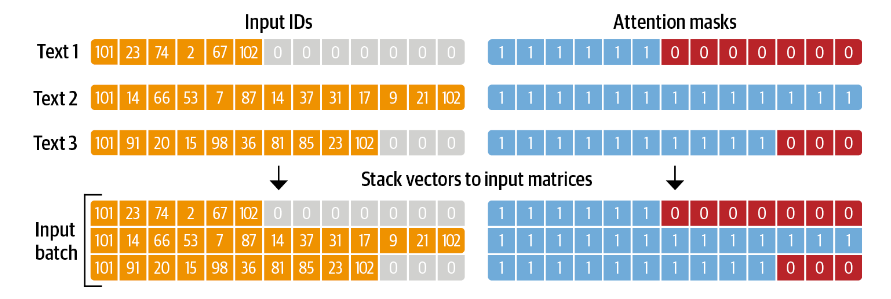

In [40]:

#hide_input
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x: x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T


,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


    Tokenizing the whole dataset

In [41]:
def tokenize(batch):
    return tokenizer(batch["text_clean"], padding="max_length", truncation=True)


train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
valid_dataset = valid_dataset.map(tokenize, batched=True, batch_size=len(valid_dataset))

Map: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25535/25535 [00:20<00:00, 1224.55 examples/s]


## Training a classifier

Models like DistilBERT are pretrained to predict masked words in a sequence of text. However, we can't use these language models directly for text classification; we need to modify them slightly. To understand what modifications are necessary

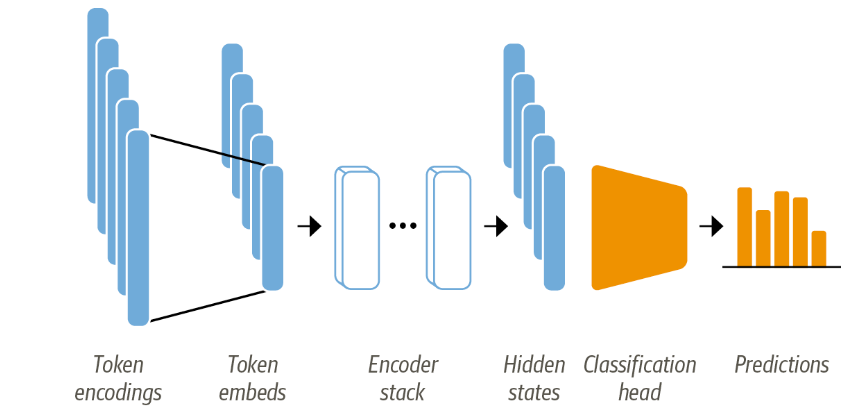

First, the text is tokenized and represented as one-hot vectors called token encodings. The size of the tokenizer vocabulary determines the dimension of the token encodings, and it usually consists of 20k–200k unique tokens. Next, these token encodings are converted to token embeddings, which are vectors living in a lower-dimensional space. The token embeddings are then passed through the encoder block layers to yield a hidden state for each input token. For the pretraining objective of language modeling. In the case of DistilBERT, it's guessing the masked tokens , each hidden state is fed to a layer that predicts the masked input tokens. For the classification task, we replace the language modeling layer with a classification layer.

We have two options to train such a model on our  dataset:

Feature extraction:: We use the hidden states as features and just train a classifier on them, without modifying the pretrained model.
Fine-tuning:: We train the whole model end-to-end, which also updates the parameters of the pretrained model.

In [42]:
base_model_id = "distilbert-base-uncased"

epochs = 5
num_labels = 2 
learning_rate = 5e-5
train_batch_size = 16
eval_batch_size = 32
save_strategy = "no"
save_steps = 500
logging_steps = 100
model_dir = "./model"

In [43]:
training_args = TrainingArguments(
    output_dir=model_dir,
    num_train_epochs=epochs,
    per_device_train_batch_size=train_batch_size,
    per_device_eval_batch_size=eval_batch_size,
    save_strategy=save_strategy,
    save_steps=save_steps,
    evaluation_strategy="epoch",
    learning_rate=learning_rate,
    logging_steps=logging_steps,
)

In [44]:
 trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
)

In [45]:
trainer.train() 

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

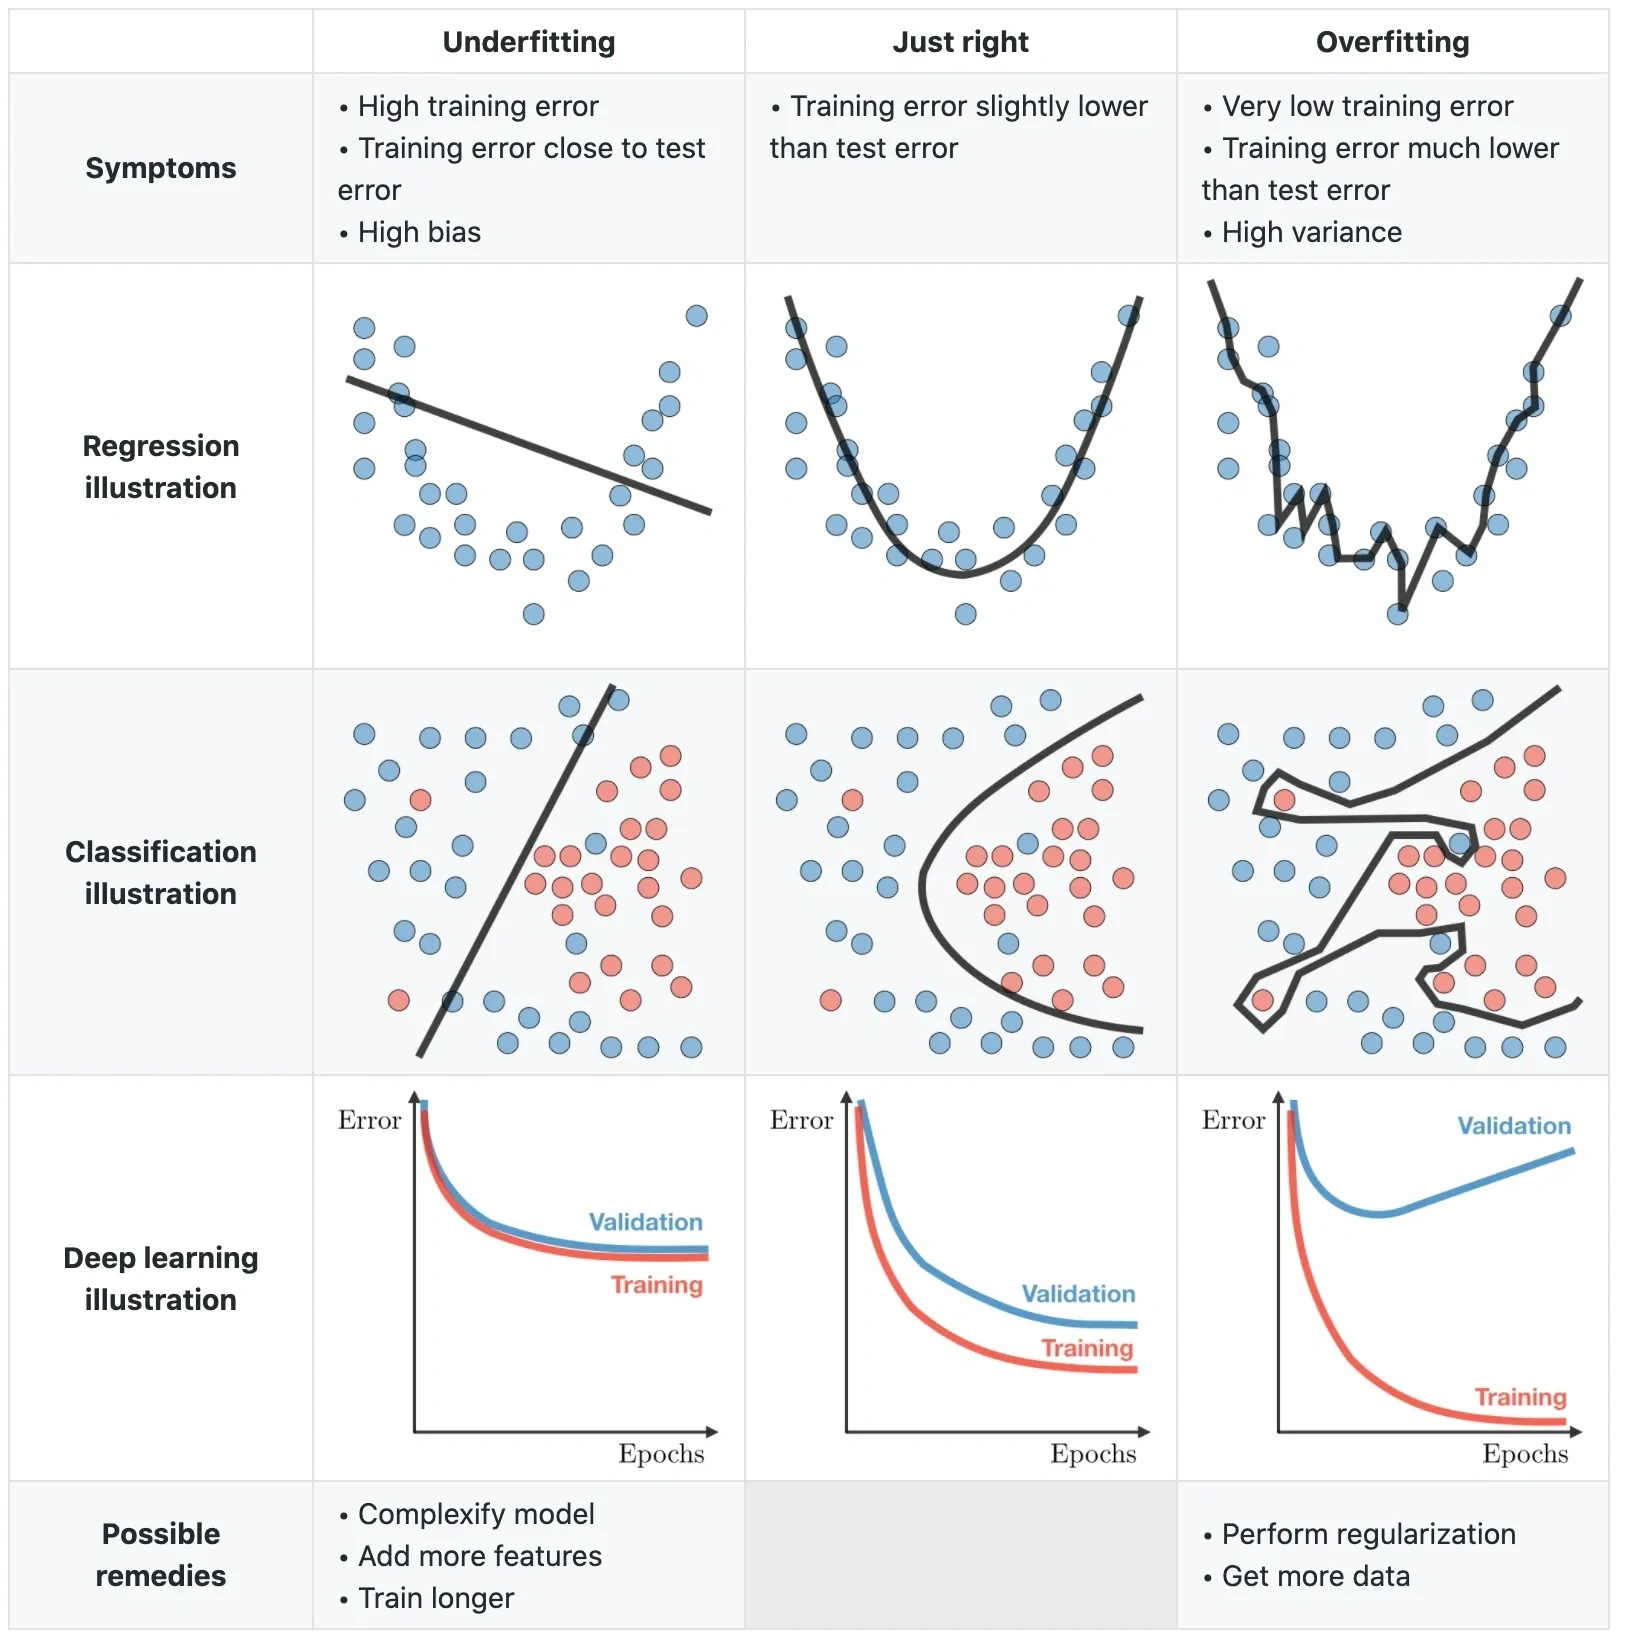

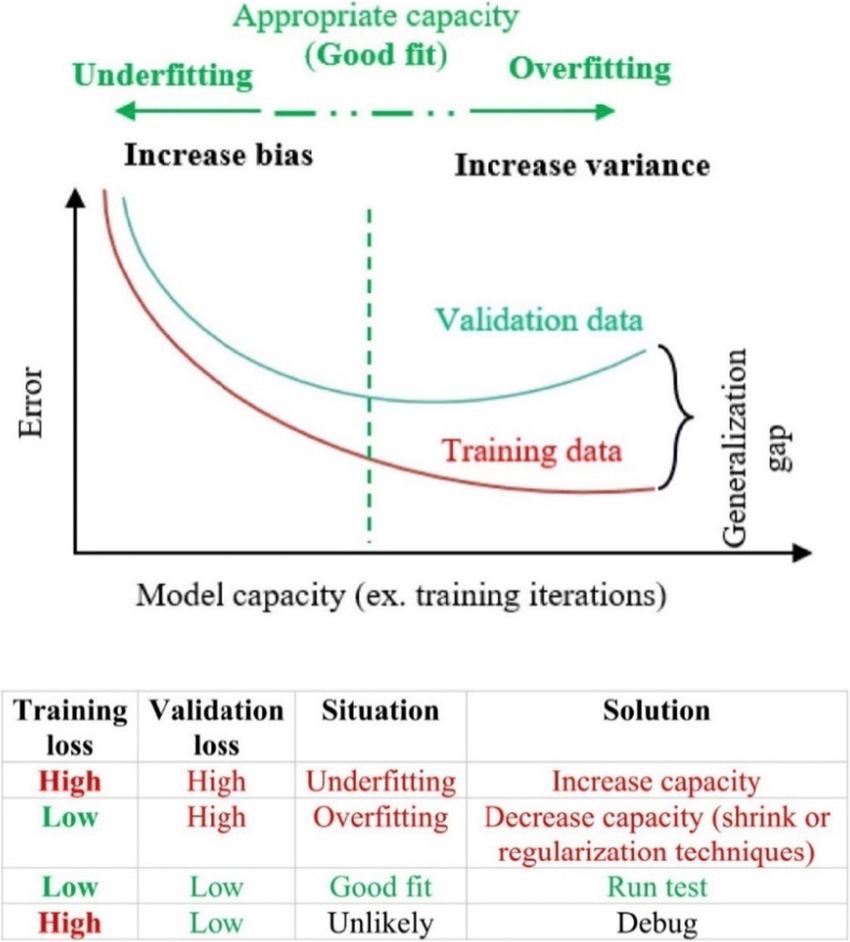

In [29]:
eval_result = trainer.evaluate(eval_dataset=valid_dataset)



The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text_clean. If text_clean are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 25535
  Batch size = 32


Trainer is attempting to log a value of "[0.88605639 0.85635873]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8843485 0.8584487]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8877709 0.8542789]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


In [33]:
for key, value in sorted(eval_result.items()):
    print(f"{key} = {value}\n")
    


epoch = 5.0

eval_accuracy = 0.8729195222243978

eval_f1 = [0.88605639 0.85635873]

eval_loss = 0.8015605807304382

eval_precision = [0.8843485 0.8584487]

eval_recall = [0.8877709 0.8542789]

eval_runtime = 226.4413

eval_samples_per_second = 112.767

eval_steps_per_second = 3.524



In [31]:
trainer.save_model(model_dir + "_local") 

Saving model checkpoint to ./model_local
Configuration saved in ./model_local/config.json
Model weights saved in ./model_local/pytorch_model.bin
tokenizer config file saved in ./model_local/tokenizer_config.json
Special tokens file saved in ./model_local/special_tokens_map.json


In [21]:
from transformers import pipeline
    
classifier = pipeline("text-classification", model="./model_local")

Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [22]:
classifier.model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [23]:
classifier("Woo hoo almost done")

[{'label': 'LABEL_0', 'score': 0.9996711015701294}]

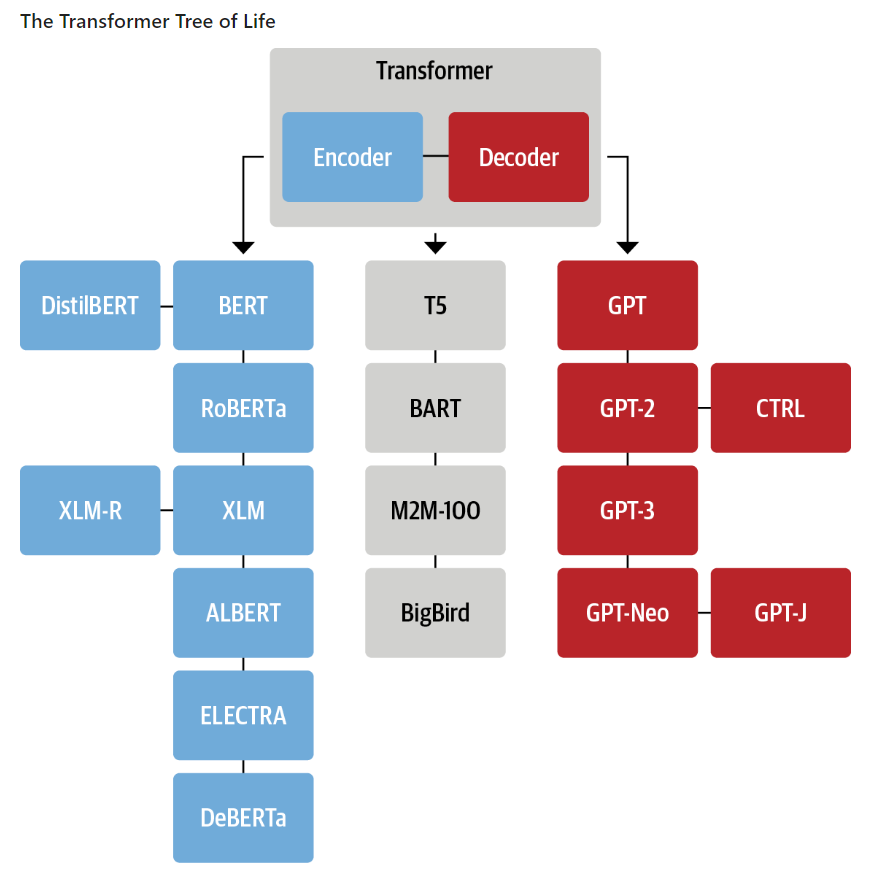

In [40]:
del train_dataset

In [41]:
del valid_dataset

In [37]:
del model

In [42]:
import torch
torch.cuda.empty_cache()

In [43]:
!nvidia-smi

Tue Aug  2 23:46:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| 22%   25C    P8    15W / 250W |      1MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:23:00.0 Off |                  N/A |
| 22%   

In [ ]:
del mode

In [ ]:
dataset = load_dataset('csv', data_files='../input/chaii-hindi-and-tamil-question-answering/train.csv', split="train")

splits = dataset.train_test_split(test_size=0.2, seed=2021) # sklearn syntax
splits

dataset.to_csv("dataset.csv", index=False) #  pandas syntax



In [ ]:
 torch.cuda.set_device(1)
 torch.cuda.current_device()